In [21]:
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from astropy.stats import sigma_clipped_stats
from astropy.convolution import Moffat2DKernel
from astropy.stats import mad_std
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import convolve as scipy_convolve
from photutils.segmentation import make_source_mask
from fonctions import *

In [22]:
# Opening the images
hdul = fits.open('image.fit')
hdul.info()

img = fits.getdata('image.fit')
bias = fits.getdata('bias.fit')
dark = fits.getdata('dark.fit')
flat = fits.getdata('flat.fit')

Filename: image.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      32   (6248, 4176)   int16 (rescales to uint16)   


/tmp/ipykernel_664542/3271461129.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cax=cax, orientation='vertical')
/tmp/ipykernel_664542/3271461129.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cax=cax, orientation='vertical')
/tmp/ipykernel_664542/3271461129.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cax=cax, orientation='vertical')
/tmp/ipykernel_664542/3271461129.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor rel

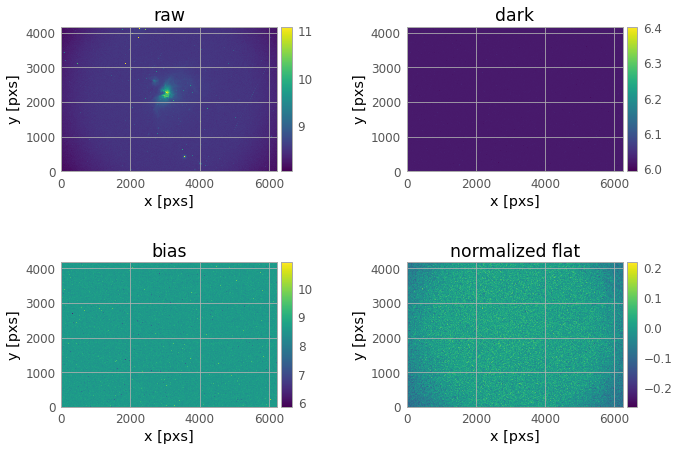

In [3]:
# Plotting all images
fig, axs = plt.subplots(2, 2)

im = axs[0,0].imshow(np.log(img), interpolation='none', origin='lower', cmap='viridis')
axs[0,0].set_title('raw')
axs[0,0].set_xlabel('x [pxs]')
axs[0,0].set_ylabel('y [pxs]')
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[0,1].imshow(np.log(dark), interpolation='none', origin='lower', cmap='viridis')
axs[0,1].set_title('dark')
axs[0,1].set_xlabel('x [pxs]')
axs[0,1].set_ylabel('y [pxs]')
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1,0].imshow(np.log(bias), interpolation='none', origin='lower', cmap='viridis')
axs[1,0].set_title('bias')
axs[1,0].set_xlabel('x [pxs]')
axs[1,0].set_ylabel('y [pxs]')
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axs[1,1].imshow(np.log(flat/np.mean(flat)), interpolation='none', origin='lower', cmap='viridis')
axs[1,1].set_title('normalized flat')
axs[1,1].set_xlabel('x [pxs]')
axs[1,1].set_ylabel('y [pxs]')
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.subplots_adjust(left=0.,
                    bottom=0., 
                    right=1, 
                    top=1, 
                    wspace=0.5, 
                    hspace=0.2)
plt.show()

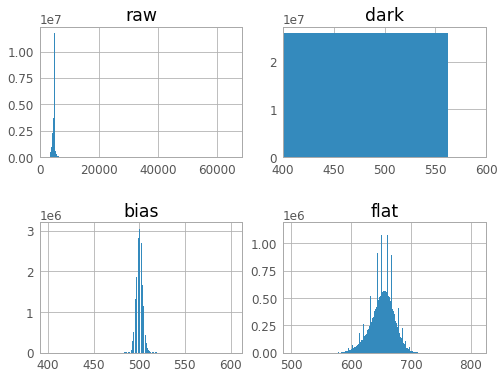

In [4]:
# Histogramm of all images
fig, axs = plt.subplots(2,2)
axs[0,0].set_title('raw')
axs[0,0].hist(img.flatten(), bins=256)
#darks = [d for d in dark.flatten() if d < 1000]
axs[0,1].set_title('dark')
axs[0,1].hist(dark.flatten(), bins=256)
axs[0,1].set_xlim(400, 600)
axs[1,0].set_title('bias')
axs[1,0].hist(bias.flatten(), bins=256)
axs[1,1].set_title('flat')
axs[1,1].hist(flat.flatten(), bins=256)
plt.show()

/tmp/ipykernel_664542/1876728087.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


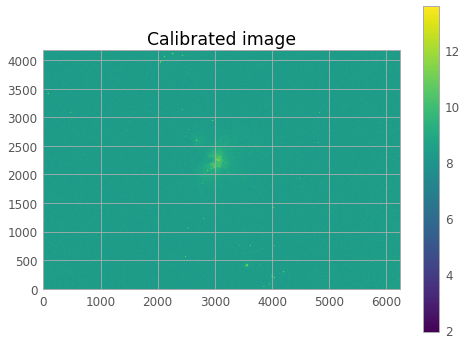

In [24]:
# Image calibrated using the different calibration frames
image_clean = calibrate(img, bias, dark, flat)
plt.figure()
plt.title('Calibrated image')
#norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(np.log(image_clean), origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

BRUTE FORCE: mean, median, std = 4866.153987896817, 4868.0, 223.8729349943459
CLIPPED: mean, median, std = 4792.625499126768, 4870.0, 333.7904221298404
MASKED: mean, median, std = 4797.0670474057915, 4871.0, 303.8868424311456


/tmp/ipykernel_653208/842673672.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


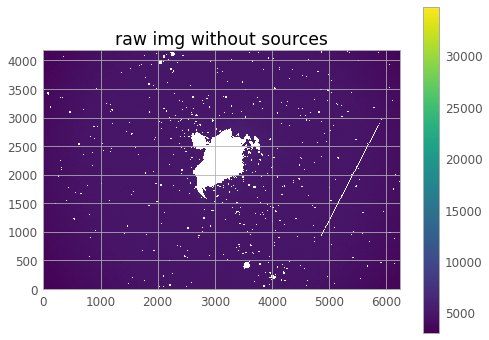

In [11]:
# SOURCE: https://photutils.readthedocs.io/en/stable/background.html

#just average estimate to characterise background
print('BRUTE FORCE: mean, median, std = {}, {}, {}'.format(np.mean(img), np.median(img), mad_std(img)))

# using clipped statistics to characterise background
mean, median, std = sigma_clipped_stats(img, sigma=3.0)
print('CLIPPED: mean, median, std = {}, {}, {}'.format(mean, median, std))

# masking sources
mask = make_source_mask(img, nsigma=3, npixels=5, dilate_size=11)
mean, median, std = sigma_clipped_stats(img, sigma=3.0, mask=mask)
masked_image = np.ma.masked_where(mask, img)
print('MASKED: mean, median, std = {}, {}, {}'.format(mean, median, std))
plt.figure()
plt.title('raw img without sources')
plt.imshow(masked_image, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

BRUTE FORCE: mean, median, std = inf, 4281.252307741206, 223.8729349943459


CLIPPED: mean, median, std = 4300.189729862813, 4266.2903417942825, 444.59392539344327


MASKED: mean, median, std = 4295.268603941227, 4263.2026316606, 440.28655745791116


/tmp/ipykernel_653208/3134898104.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


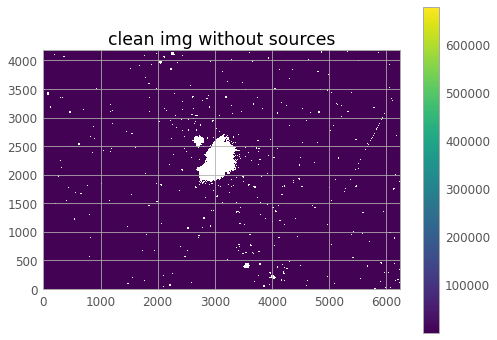

/tmp/ipykernel_653208/3134898104.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


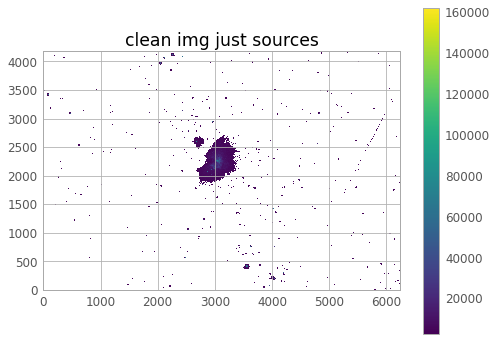

In [12]:
# SOURCE: https://photutils.readthedocs.io/en/stable/background.html

#just average estimate to characterise background
print('BRUTE FORCE: mean, median, std = {}, {}, {}'.format(np.mean(image_clean), np.median(image_clean), mad_std(img)))

# using clipped statistics to characterise background
mean, median, std = sigma_clipped_stats(image_clean, sigma=3.0)
print('CLIPPED: mean, median, std = {}, {}, {}'.format(mean, median, std))

# masking sources
mask = make_source_mask(image_clean, nsigma=4, npixels=5, dilate_size=11)
mean, median, std = sigma_clipped_stats(image_clean, sigma=3.0, mask=mask)
masked_image = np.ma.masked_where(mask, image_clean)
print('MASKED: mean, median, std = {}, {}, {}'.format(mean, median, std))
plt.figure()
plt.title('clean img without sources')
plt.imshow(masked_image, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('clean img just sources')
inverted_masked_image = np.ma.masked_where(np.logical_not(mask), image_clean)
plt.imshow(inverted_masked_image, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [29]:
# Image calibrated using the different calibration frames
image_clean = calibrate(img, bias, dark, flat)
plt.figure()
plt.title('Calibrated image')
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(image_clean, norm=norm, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

KeyboardInterrupt: 

In [3]:
# Estimation of the 2D background value variation
sigma_clips = SigmaClip(sigma=4.0)
bkg_estimator = MedianBackground()
bkg = Background2D(image_clean, (116, 142), mask=mask, filter_size=(3,3), sigma_clip = sigma_clips, bkg_estimator=bkg_estimator)

plt.figure()
plt.title('2D background map')
plt.imshow(bkg.background, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

image_calibrated = image_clean - bkg.background
#image_calibrated = np.where(image_calibrated<0, 0, image_calibrated)
image_calibrated = -np.min(image_calibrated) + image_calibrated
plt.figure()
plt.title('Calibrated image without 2D background map')
plt.imshow(image_clean, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
bkg.plot_meshes(outlines=True, color='#1f77b4')
plt.show()

NameError: name 'image_clean' is not defined

In [4]:
# Histogramm of the remaining background noise
print(np.min(image_calibrated))
plt.figure()
plt.hist(image_calibrated.flatten(), bins=256)
plt.xlim(-1000, 5000)
plt.show()

NameError: name 'image_calibrated' is not defined

In [5]:
# PSF of one star
PSF = image_clean[2926-10:2926+10, 2029-10:2029+10]
PSF = PSF / np.sum(PSF) #normalized as a distribution to 1
plt.figure()
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(PSF, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

NameError: name 'image_clean' is not defined

/tmp/ipykernel_469490/3341941316.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


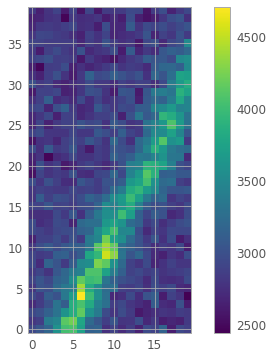

In [15]:
# small outcut of a track
track = image_calibrated[1720:1760,5260:5280]
plt.figure()
plt.imshow(track, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

/tmp/ipykernel_469490/2894964873.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


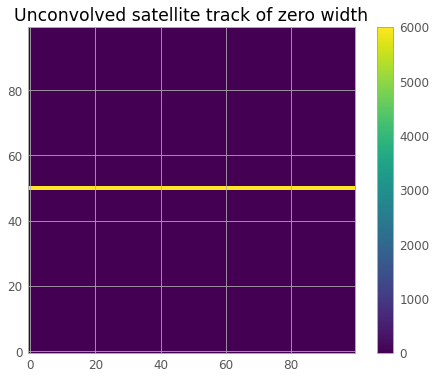

In [16]:
#Now we create a model of the *unconvolved* satellite track (an empty array with ones where the satellite is)
track = np.zeros((100, 100))

#just have it horizontal for now around the middle, but later you can adapt this to be at an angle; also look into convolving on an oversampled grid to avoid problems
track[50, :] = 6e3
plt.imshow(track, origin='lower', cmap='viridis')
plt.title('Unconvolved satellite track of zero width')
plt.colorbar()
plt.show()

/tmp/ipykernel_469490/3962773586.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


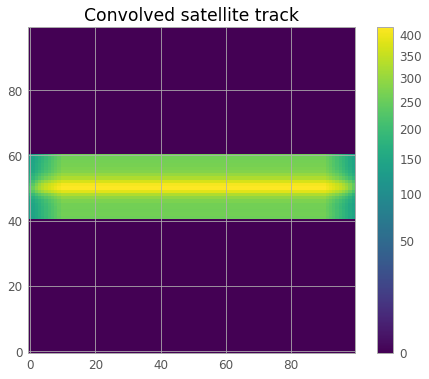

In [17]:
track_conv = scipy_convolve(track, PSF, mode='same', method='direct')

plt.imshow(track_conv, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Convolved satellite track')
plt.show()

In [ ]:
darks = [d for d in dark.flatten() if d < 750]
plt.figure()
plt.hist(darks, bins=256)
plt.show()